In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
PREFIX = '.'
SHAPE = (197, 233, 189)
MODEL_PATH = f'{PREFIX}/models/vit/multi_class_5_4/vit_vit_(197, 233, 189)_[128]_0.0001_32_0.1_18_10_361_256_4_[512, 256]_0.15_checkpoint.h5'
TF_RECORD_PATH = f'{PREFIX}/data/tfrecords/tf_dataset.tfrecord'

In [ ]:
def parse_example(example):
  features = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
  }
  example = tf.io.parse_single_example(example, features)
  image = tf.io.decode_raw(example['image'], tf.float32)
  image = tf.reshape(image, SHAPE)
  image = tf.reshape(image, (SHAPE[0], SHAPE[1], SHAPE[2]))
  #one_hot = tf.one_hot(example['label'], 2)
  return image, example['label']

def load_tfrecord(tfrecord_path):
  dataset = tf.data.TFRecordDataset(tfrecord_path)
  dataset = dataset.map(parse_example)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  #dataset = dataset.cache()
  return dataset

In [ ]:

class MLP(layers.Layer):
  def __init__(self, hidden_units=[128, 64], dropout_rate=0.1, activation="gelu", kernel_regularizer=None, **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dropout_rate = dropout_rate
    self.hidden_units = hidden_units
    self.activation = activation
    self.kernel_regularizer = kernel_regularizer
    for i, units in enumerate(hidden_units):
      setattr(self, f'dense_{i}', layers.Dense(units, activation=self.activation, kernel_regularizer=kernel_regularizer))
      setattr(self, f'dropout_{i}', layers.Dropout(dropout_rate))

  def get_config(self, **kwargs):
    config = super().get_config()
    config_dict = {
        "dropout_rate": self.dropout_rate,
        "hidden_units": self.hidden_units,
        "activation": self.activation,
        "kernel_regularizer": self.kernel_regularizer
    }
    config.update(config_dict)
    return config

  def call(self, x, training=None, **kwargs):
    for i, _ in enumerate(self.hidden_units):
      x = getattr(self, f'dense_{i}')(x)
      x = getattr(self, f'dropout_{i}')(x, training=training)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def get_config(self, **kwargs):
      config = super().get_config()
      config_dict = {
          "patch_size": self.patch_size
      }
      config.update(config_dict)
      return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim=64, **kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=self.projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=self.projection_dim
        )

    def get_config(self):
      config = super().get_config()
      config_dict = {
          "num_patches": self.num_patches,
          "projection_dim": self.projection_dim
      }

      config.update(config_dict)
      return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def plot_3d_array_image(volume_img_array, slice_to_plot=64, cmap='gray'):
    plt.imshow(volume_img_array[slice_to_plot], cmap=cmap)
    plt.show()

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(np.array([img_path]))
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            #print(preds, preds.shape)
            #print('Predicted class:', pred_index.numpy())
        class_channel = preds[:, pred_index]
        #print('class_channel', class_channel, class_channel.shape)
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    #print('last_conv_layer_output', last_conv_layer_output.shape)
    #print('grads', grads.shape)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    #print('pooled_grads', pooled_grads.shape)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    #print('last_conv_layer_output', last_conv_layer_output.shape)
    #print('pooled_grads[..., tf.newaxis]', pooled_grads[..., tf.newaxis].shape)
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    #print('heatmap', heatmap.shape)
    heatmap = tf.squeeze(heatmap)
    #print('heatmap', heatmap.shape)
    return heatmap

In [ ]:
tf_dataset = load_tfrecord(TF_RECORD_PATH)
mri_x_array = None
mri_y_array = None

for x, y in tf_dataset.take(1):
  mri_x_array = x.numpy()
  mri_y_array = y.numpy()
  break

In [ ]:
img_size = SHAPE
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

model = tf.keras.models.load_model(MODEL_PATH, custom_objects={ 'MLP': MLP, 'Patches': Patches, 'PatchEncoder': PatchEncoder }, compile=False)

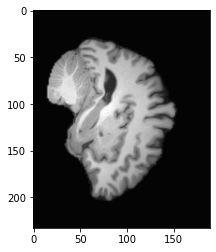

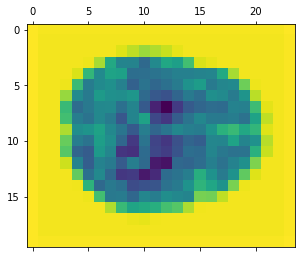

In [89]:
last_conv_layer_name = model.layers[1].name

img_path = mri_x_array
slice_to_plot = 64

plot_3d_array_image(img_path, slice_to_plot, cmap='gray')

gradcam_heatmap = make_gradcam_heatmap(img_path, model, last_conv_layer_name, pred_index=None)

plt.matshow(heatmap)
plt.show()

class_channel tf.Tensor([3.8548403], shape=(1,), dtype=float32) (1,)
last_conv_layer_output (1, 20, 24, 2048)
grads (1, 20, 24, 2048)
pooled_grads (2048,)
last_conv_layer_output (20, 24, 2048)
pooled_grads[..., tf.newaxis] (2048, 1)
heatmap (20, 24, 1)
heatmap (20, 24)


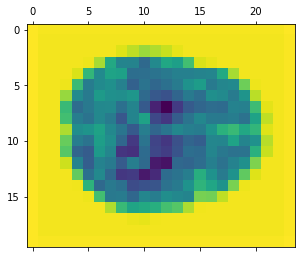

In [98]:
last_conv_layer_name = model.layers[1].name

grad_model = tf.keras.models.Model(
[model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
)
# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(np.array([img_path]))
    if pred_index is None:
        pred_index = tf.argmax(preds[0])
        print(preds, preds.shape)
        print('Predicted class:', pred_index.numpy())
    class_channel = preds[:, pred_index]
    print('class_channel', class_channel, class_channel.shape)
# This is the gradient of the output neuron (top predicted or chosen)
# with regard to the output feature map of the last conv layer
grads = tape.gradient(class_channel, last_conv_layer_output)
print('last_conv_layer_output', last_conv_layer_output.shape)
print('grads', grads.shape)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
print('pooled_grads', pooled_grads.shape)

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation
last_conv_layer_output = last_conv_layer_output[0]
print('last_conv_layer_output', last_conv_layer_output.shape)
print('pooled_grads[..., tf.newaxis]', pooled_grads[..., tf.newaxis].shape)
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
print('heatmap', heatmap.shape)
heatmap = tf.squeeze(heatmap)
print('heatmap', heatmap.shape)

plt.matshow(heatmap)
plt.show()